<a href="https://colab.research.google.com/github/deskaygraphics/My_geoai_Project/blob/main/RS_pro_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow --upgrade
# !pip install keras --upgrade
# !pip install segmentation-models --upgrade

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random


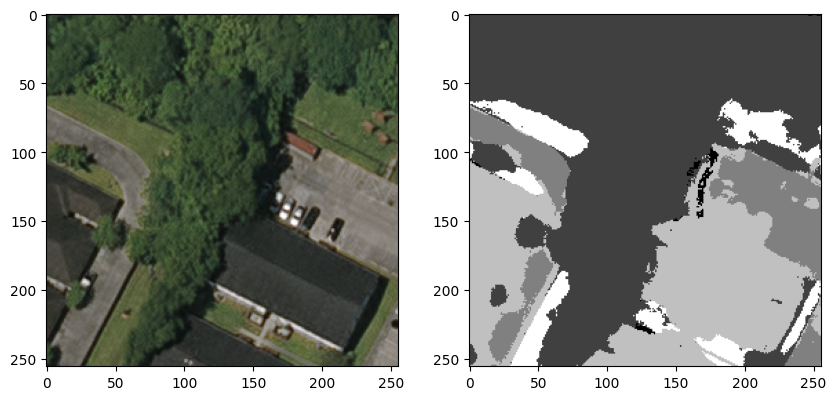

In [3]:
train_img_dir = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/train_images/images"
train_mask_dir = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/train_masks/masks"

image_id = random.choice(os.listdir(train_img_dir))
image_path = os.path.join(train_img_dir, image_id)
mask_path = os.path.join(train_mask_dir, image_id)


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(image)
axarr[1].imshow(mask, cmap='gray')
plt.show()

In [4]:
#!pip install segmentation-models

In [5]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [6]:
from keras import backend as K
from keras.models import load_model
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend

In [8]:
seed=24
batch_size= 16
n_classes=5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [9]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img,mask)

In [10]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

Found 2182 images belonging to 1 classes.
Found 2182 images belonging to 1 classes.


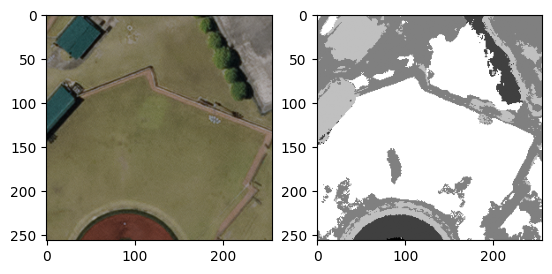

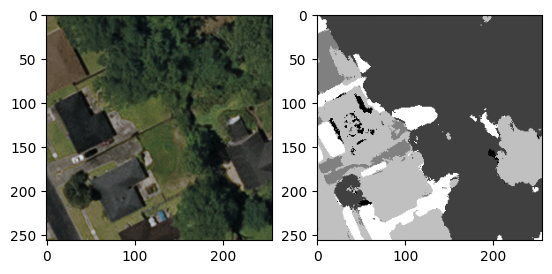

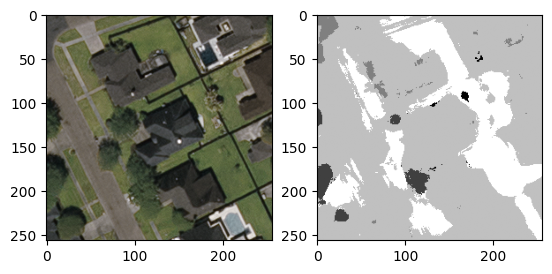

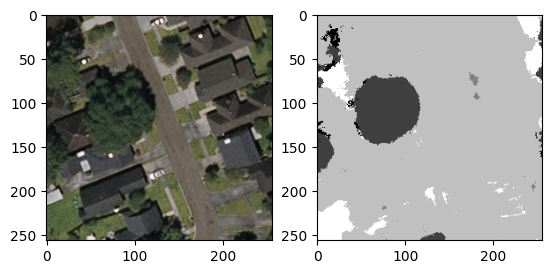

Found 728 images belonging to 1 classes.
Found 728 images belonging to 1 classes.


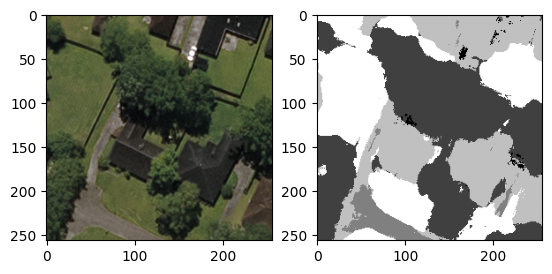

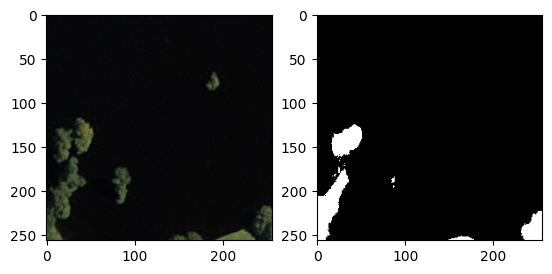

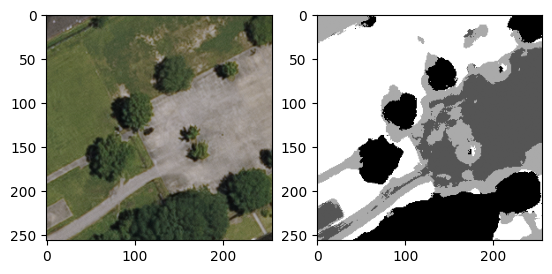

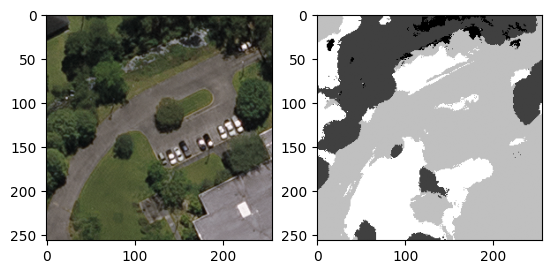

In [11]:
train_img_path = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/train_images/"
train_mask_path = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5) # Changed num_class to 5

val_img_path = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/val_images/"
val_mask_path = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5) # Changed num_class to 5


x, y = train_img_gen.__next__()

for i in range(0,4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,4):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [12]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/GeoAi/Myproj_data/Data/train_images/images'))
num_val_images = len(os.listdir('/content/drive/MyDrive/GeoAi/Myproj_data/Data/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5

In [13]:
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)
print(n_classes)

256
256
3
5


In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
import segmentation_models as sm
from tensorflow import keras
import tensorflow as tf

# Instead of trying to modify the backend directly,
# ensure you are using the correct backend for tf.keras
# This is usually handled automatically when using tensorflow.keras

model = sm.Unet(BACKBONE, encoder_weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')

# No changes are needed here as 'categorical_crossentropy' is a standard loss
# and does not depend on the 'K' alias

# Define the IOU score metric
def iou_score(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, dtype=tf.float32)

    # Use tf.reduce_sum instead of backend.sum for calculating intersection and union
    # This is because 'backend.sum' might be deprecated or unavailable.
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection

    # Calculate IOU score
    iou = (intersection + 1e-6) / (union + 1e-6)  # Adding small value to avoid division by zero

    return iou

model.compile('Adam', loss='categorical_crossentropy', metrics=[iou_score])

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
print(model.summary())
print(model.count_params())
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 256, 256, 3)    │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 128, 128, 64)   │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 128, 128, 64)   │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 64, 64, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 64, 64, 64)     │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 64, 64, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 24,456,734 (93.30 MB)

 Trainable params: 24,439,384 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None
24456734
(None, 256, 256, 3)
(None, 256, 256, 5)


In [17]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1170s 8s/step - iou_score: 0.4267 - loss: 0.7878 - val_iou_score: 0.1732 - val_loss: 344.4941
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 78s 574ms/step - iou_score: 0.6005 - loss: 0.4417 - val_iou_score: 0.1676 - val_loss: 1.5324
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - iou_score: 0.6203 - loss: 0.4286 - val_iou_score: 0.1139 - val_loss: 2.4443
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 74s 545ms/step - iou_score: 0.6141 - loss: 0.4760 - val_iou_score: 0.1504 - val_loss: 2.0377
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 79s 585ms/step - iou_score: 0.4957 - loss: 0.7681 - val_iou_score: 0.2222 - val_loss: 1.4428
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 83s 614ms/step - iou_score: 0.6280 - loss: 0.4311 - val_iou_score: 0.2025 - val_loss: 1.4258
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 81s 599ms/step - iou_score: 0.6252 - loss: 0.4157 - val_iou_score: 0.3426 - val_loss: 0.8527
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 65s 480ms/step - iou_score: 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 48s 353ms/step - iou_score: 0.6586 - loss: 0.3529 - val_iou_score: 0.6098 - val_loss: 0.4258
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


136/136 ━━━━━━━━━━━━━━━━━━━━ 52s 384ms/step - iou_score: 0.6662 - loss: 0.3395 - val_iou_score: 0.6428 - val_loss: 0.4149


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [20]:
model.save('landcover_10_epochs_RESNET_backbone_batch16.hdf5')

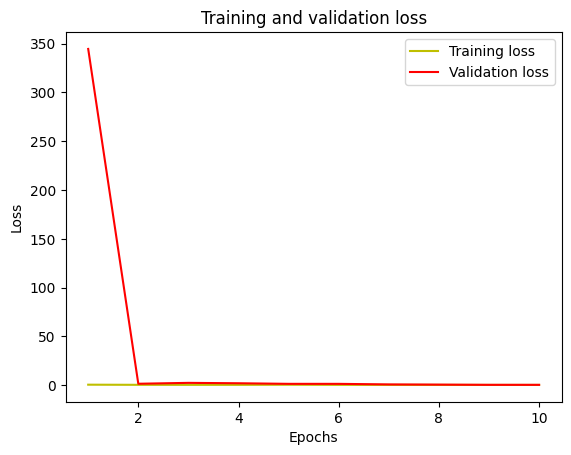

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

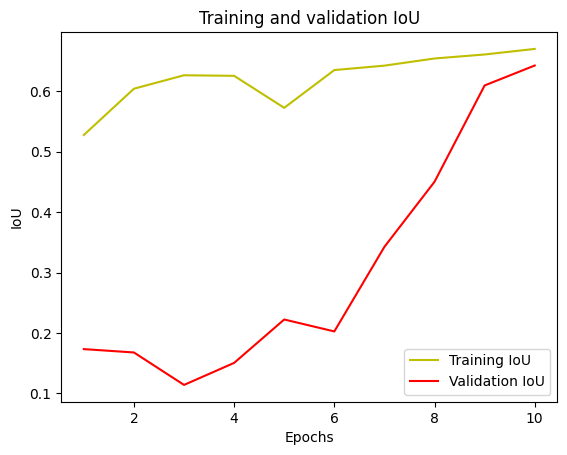

In [19]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [22]:
# When saving the model:
model.save('landcover_10_epochs_RESNET_backbone_batch16.h5')

# When loading the model:
from keras.models import load_model
model = load_model("landcover_10_epochs_RESNET_backbone_batch16.h5", compile=False)

In [25]:
from keras.models import load_model
model = load_model("landcover_10_epochs_RESNET_backbone_batch16.h5", compile=False)

# Reset the validation generator
# Create a fresh instance of the generator
val_img_path = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/val_images/"
val_mask_path = "/content/drive/MyDrive/GeoAi/Myproj_data/Data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5) # Changed num_class to 5

# Now, you can get the next batch
test_image_batch, test_mask_batch = val_img_gen.__next__()

# The rest of your code for calculating and printing the mean IoU
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# Assuming `MeanIoU` is correctly defined/imported
from tensorflow.keras.metrics import MeanIoU # Assuming this is how you import it
n_classes = 5  # Should match your actual number of classes in the dataset
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Found 728 images belonging to 1 classes.
Found 728 images belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Mean IoU = 0.69210756


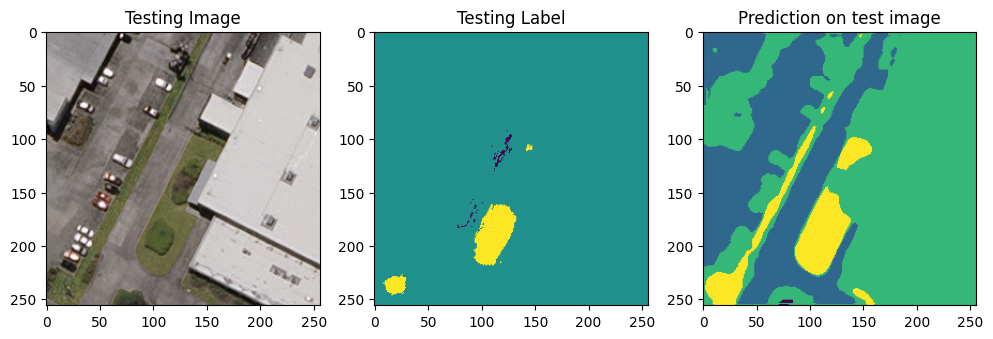

In [35]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()